In [65]:
PATH_TO_YOLO_FOLDER = '/Users/dominikocsofszki/Desktop/drive_fake/MyDrive/yolov5'
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import yaml


#filters out duplicates by center_widht -> problem float comparing > rounding up to 2 decimal
# works but depends on the image size and ammount of labels > finding solution in detectlabelme
#-not used yet?
def filter_duplicates_given_names(df, round_nr):
    filter = df.round(round_nr).duplicated(subset=['cw'], keep='first')
    return df[~filter]

#handing over the labels for filtering out all the other label_center which are in that area
#ToDo delete filtered out items
#-not used yet?
def return_filter_cw_minmax_ch_minmax(tub,df:pd.DataFrame):
    (cw_min, cw_max, hw_min, hw_max) = tub
    # print(f'{cw_min}, {cw_max}, {hw_min}, {hw_max}')
    filter_boundries = (cw_min <= df['cw']) & (df['cw'] < cw_max) & (hw_min < df['ch']) & (df['ch'] < hw_max)
    return filter_boundries


#filters all elements that lay in the label boundry of one label.
#row => is one label entry.example: 25 0.189063 0.130469 0.046875 0.0578125 0.287464
def final_return_filter_duplicates(row,df:pd.DataFrame):
    # (cw_min, cw_max, hw_min, hw_max) = row["cw"] - (row['w'] / 2), row["cw"] + (row['w'] / 2), row["ch"] - (
    #             row['h'] / 2), row["ch"] + (row['h'] / 2),
    cw_min = row["cw"] - (row['w'] / 2)
    cw_max = row["cw"] + (row['w'] / 2)
    hw_min = row["ch"] - (row['h'] / 2)
    hw_max = row["ch"] + (row['h'] / 2)
    filter_boundries = (cw_min <= df['cw']) & (df['cw'] < cw_max) & (hw_min < df['ch']) & (df['ch'] < hw_max)
    return filter_boundries


#for birectional keys. Return for the class_nr the value
def get_key(my_dict, val):  #better way for sure possible
    for key, value in my_dict.items():
        if val == value:  #string compare no equals???
            return key


#reads the yaml file, adds the path:... to the yaml files and saves it
#NOT 100% SURE IF WRITING THE PATH WORKS YET, TO BE TESTED, BUT NOT NEEDED YET
#returns the yaml file for next function dict
def change_and_return_yaml_dict(path_to_yaml_folder):
    label_folder = Path(path_to_yaml_folder)
    fname = label_folder / 'data.yaml'
    with open(fname) as f:
        yaml_load = yaml.safe_load(f)
    yaml_load["path"] = str(label_folder.resolve())
    with open(fname, "w") as f:
        yaml.dump(yaml_load, f, default_flow_style=False)
        return yaml_load


#reads the yaml file and returns a dict for all the data.yaml entries and
# returns the dict_class for translating class_nr to class_name
def dict_classes_and_yaml(data_yaml_source):
    dict_yaml = change_and_return_yaml_dict(data_yaml_source)
    dict_classes = dict(enumerate(map(str, dict_yaml.get('names'))))
    return dict_classes, dict_yaml

#reads the csv and add the headers
#cw = center width, ch = center height, w = width of label, h = height of label, p = accuracy of label
def read_csv_new_header(csv_txt_path) :
    # df = pd.read_csv(csv_txt_path,header=None,names=('class_nr','ch','cw','h','w','p'))
    df = pd.read_csv(csv_txt_path,names=['class_nr','cw','ch','w','h','p'],delimiter=' ')
    return df

##WORKING PLEASE NO CHAGE!!
#checks all labels in one image
#here you can also change the colour of the first x labels, since they have the highest accuracy,
#You can also add a list with items that have been change, to make changes visible
def check_label_all(df:pd.DataFrame, img, above_center=-30, first_x_labels_diff_colour=50,
                    list_index_changed_before=None):
    if list_index_changed_before is None:
        list_index_changed_before = []      #showing changes if any
    plt.rcParams['figure.dpi'] = 250    #<change if img to small#increase size to be better able to read images on screen
    plot, ax = plt.subplots()
    w = img.shape[0]
    h = img.shape[1]
    col_changing = 'green'        # picking coulour to show

    for i in range(df.shape[0]):
        df_entry = df.iloc[i]
        hmp = df_entry[1] * h       #calculate borders in pixel size, before was i percentage of img
        wmp = df_entry[2] * w
        # print(df_entry)
        # col_changing = 'red'        # picking coulour to show
        # if i <= first_x_labels_diff_colour: col_changing = 'pink' ##Not so bright entries for high accuracy
        if i in list_index_changed_before: col_changing = 'black'  ##<<----Will not work, after first all will change to green ##Changed labels
        if i == 50 :
            # above_center = above_center+10
            col_changing = 'red'
        if i == 100 :
            # above_center = above_center+10
            col_changing = 'black'
        ax.plot(hmp, wmp + above_center, marker='$' + str(i) + ',' + '$', color=col_changing, ms=8)
    # plt.title("test")
    ax.plot()
    # ax.imshow(plt.imread(path_to_image))
    ax.imshow(img)
    ax.plot()
##until

##To only show the line with the selected row, row(indx)
def final_filter_out_one_line(df:pd.DataFrame,indx:int) :
    filter = return_filter_cw_minmax_ch_minmax((0,1,df.iloc[indx]['cw']-df.iloc[indx]['w']/2,df.iloc[indx]['cw']+df.iloc[indx]['w']/2),df=df)
    return filter

#dict to find all paths related to Yolov5 folder
##If you want to change sth, better add a new dict with new path instead of changing any old ones!
def path_to_yolo_return_dict_paths(PATH_TO_YOLO_FOLDER):
    yolo = Path(PATH_TO_YOLO_FOLDER).absolute()
    print(f'yolo:{yolo}')
    labelme = yolo.parent / 'labelme'
    detect_labelme = labelme / 'detect_labelme.py'
    runs = labelme / 'runs'
    override_no_inc = runs / 'detect' / 'override_no_inc'
    copy = labelme / 'copy'
    weight = labelme / 'weight'
    weight_best = labelme / 'weight' / 'best.pt'
    detect = yolo / 'detect.py'
    detect_folder = runs / 'detect'
    #labelme.py
    labelme_py = yolo/'detect_labelme.py'
    train = yolo / 'train.py'
    labels = override_no_inc / 'labels'
    source = override_no_inc / 'source'
    yaml = weight / 'data.yaml'
    original_source = labelme / 'source'
    labelme_source = labelme / 'source'
    screenshots = labelme/'source'

    dict_paths = {
        'labelme_py':labelme_py,
        'labelme_source': labelme_source,
        'detect_folder': detect_folder,
        'original_source': original_source,
        'yaml': yaml,
        'original': source,
        'labels': labels,
        'labelled_pic': override_no_inc,
        'override': override_no_inc,
        'train': train,
        'detect': detect,
        'yolo': yolo,
        'labelme': labelme,
        'source': source,
        'detect_labelme': detect_labelme,
        'runs': runs,
        'copy': copy,
        'weight': weight,
        'weight_best': weight_best,
        'screenshots': screenshots
    }
    for x in dict_paths:
        asd=''
        # print(f'{x}: {dict_paths[x]}')
    return dict_paths

dict_path = path_to_yolo_return_dict_paths(PATH_TO_YOLO_FOLDER) #produces the dict for paths


# x = dict_path['labels'].iterdir()       # gives us a list of all labels in the folder

# entries = [entry for entry in dict_path['labels'].iterdir()]    #makes the label list iterable

def return_path_entries_folder(path_to_img_folder:Path) :
    entries = [entry for entry in path_to_img_folder.iterdir()] ##need to ignore other files!?!?<<<<<<<<
    entries.sort()
    return entries

def full_run_labelme(above_center:int=35) :
    dict_classes, _ = dict_classes_and_yaml(dict_path['weight']) # path to data.yaml, top folder
    # entries_images = return_path_entries_folder(dict_path['source'])
    # entries_images = return_path_entries_folder(dict_path['screenshots'])
    entries_images = return_path_entries_folder(dict_path['override'])
    entries_labels = return_path_entries_folder(dict_path['labels'])
    path_to_labels = dict_path['labels']
    for img_path in entries_images :
        if not img_path.is_file() : continue        ##Ignore items that are not files
        # labels_path = entries_labels/img_path.stem/'.txt'
        labels_path = (path_to_labels/(img_path.stem+'.txt'))
        ##
        if not labels_path in entries_labels :      ##Happens if nothing was detected
            print(f'Missing Label: {img_path.stem}')    ##Could also put it into a file later
            continue
        ##
        df = read_csv_new_header(labels_path)       ##Reads the .txt file
        # dict_classes[]

        df['dict'] = df['class_nr'].map(dict_classes) ## produces a new Colum with the dict to the class_nr

        print(df)
        img = plt.imread(img_path)  ##reads the image
        #here i wanted to filter out all duplicates with different function,

        for i in range(df.shape[0]):        ##For filtering out duplicates >>>Not used yet
            filter_find_duplicates_one_entry = final_return_filter_duplicates(df.iloc[i],df=df)
            #here i wanted to filter out all duplicates with different function,

            #needs to be finished, for now we use the other filter
        df_noduplicate = filter_duplicates_given_names(df, 3) ## Filters out duplicates, rounds on float,3

##        # check_label_all(df=df_noduplicate.sort_values('cw'),img=img,above_center = - above_center)##calc above

        # df_sort_for_cw = df_noduplicate.sort_values('cw')#<<<<<<<<
        # df_sort_for_cw = df_noduplicate.sort_values('ch')#<<<<<<<<
        df_sort_for_cw = df_noduplicate.sort_values('p')

        # check_label_all(df=df_sort_for_cw,img=img,above_center = - above_center, first_x_labels_diff_colour=200)##calc above
        check_label_all(df=df,img=img,above_center = - above_center, first_x_labels_diff_colour=200)##calc above
        plt.title(str(img_path.name))  ##add it here <<<

        df.to_csv(labels_path.with_suffix('.csv'),sep=',')
        # df_sort_for_cw.to_csv(labels_path.with_suffix('.csv'),sep=',')
        # df.to_csv()
        # input()       ##<<delete me
        # break

yolo:/Users/dominikocsofszki/Desktop/drive_fake/MyDrive/yolov5


In [66]:
# def read_csv_with_dict(csv_txt_path) :
#     # df = pd.read_csv(csv_txt_path,header=None,names=('class_nr','ch','cw','h','w','p'))
#     # df = pd.read_csv(csv_txt_path,names=['class_nr','cw','ch','w','h','p','dict'],delimiter=',',header = None)
#     df = pd.read_csv(csv_txt_path,names=['class_nr','cw','ch','w','h','p','dict'],delimiter=',')
#     # df = pd.read_csv(csv_txt_path,delimiter=' ',header=None)
#     return df
# def read_changed_label_csv_into_label_txt(csv_path) :
#     df = read_csv_with_dict(csv_path)
#     print(f'df:{df}')
#     df.drop(columns='dict')
#     print(df)
#     print('to be implemented')
#
#
# read_changed_label_csv_into_label_txt('/Users/dominikocsofszki/Desktop/drive_fake/MyDrive/labelme/runs/detect/override_no_inc/labels/labme 2022-12-04 at 12.01.18.csv')


FileNotFoundError: [Errno 2] No such file or directory: '/Users/dominikocsofszki/Desktop/drive_fake/MyDrive/labelme/runs/detect/override_no_inc/labels/labme 2022-12-04 at 12.01.18.csv'

In [67]:
count_copies = 40

yolo:/Users/dominikocsofszki/PycharmProjects/checklabel/../../Desktop/drive_fake/MyDrive/yolov5
labelme_source: /Users/dominikocsofszki/PycharmProjects/checklabel/../../Desktop/drive_fake/MyDrive/labelme/source
detect_folder: /Users/dominikocsofszki/PycharmProjects/checklabel/../../Desktop/drive_fake/MyDrive/labelme/runs/detect
original_source: /Users/dominikocsofszki/PycharmProjects/checklabel/../../Desktop/drive_fake/MyDrive/labelme/source
yaml: /Users/dominikocsofszki/PycharmProjects/checklabel/../../Desktop/drive_fake/MyDrive/labelme/weight/data.yaml
original: /Users/dominikocsofszki/PycharmProjects/checklabel/../../Desktop/drive_fake/MyDrive/labelme/runs/detect/override_no_inc/source
labels: /Users/dominikocsofszki/PycharmProjects/checklabel/../../Desktop/drive_fake/MyDrive/labelme/runs/detect/override_no_inc/labels
labelled_pic: /Users/dominikocsofszki/PycharmProjects/checklabel/../../Desktop/drive_fake/MyDrive/labelme/runs/detect/override_no_inc
override: /Users/dominikocsofszki

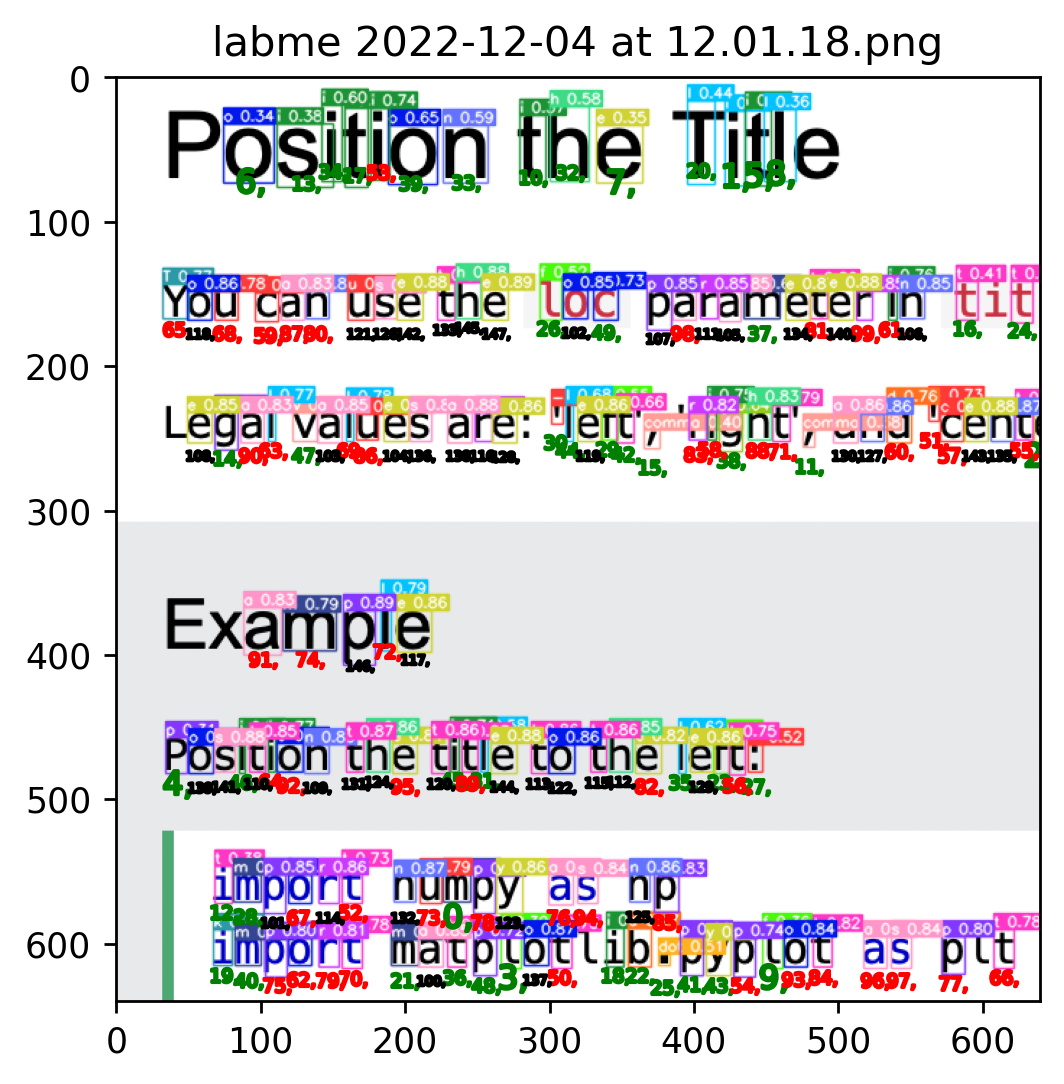

In [68]:


##Labels screenshots, upload in folder override_no_inc
DETECT_LABELME_PATH = '/Users/dominikocsofszki/Desktop/drive_fake/MyDrive/yolov5/detect_labelme.py'
# DETECT_LABELME_PATH = str(dict_path['labelme_py'])+'.py'
# print(DETECT_LABELME_PATH)

# !python {DETECT_LABELME_PATH} --device 'cpu' --max-det 100
# !python {DETECT_LABELME_PATH} --device 'cpu' --classes 0 1 2 3
!python {DETECT_LABELME_PATH} --device 'cpu' --agnostic-nms             #<<<148 items
# !python {DETECT_LABELME_PATH} --device 'cpu'                                ##178 items!!!!

# full_run_labelme(above_center = 35)

# !python {DETECT_LABELME_PATH} --device 'mps'

##runs over these images shows, cleans up duplicates, shows you the new labels
source = dict_path['override']
dest = source.parent
count_copies = count_copies + 1
dest_new = str(dest) +'_'+str(count_copies)
# print(source,dest)
full_run_labelme(above_center = -20)

# input('Check your new csv and change, press enter to load csv into .txt')
# ##Needs to be set before: count_copies = 0
# !mv {source} {dest_new}   #Moves the folder into labelme/runs -> deletes the old folder
# !cp -R {source} {dest_new}    ##Copies the folder into labelme/runs <<<<<<<<<<with this adds more and more to the text file!

##saves the new labels as csv
#->open csv and correct labels in there, index =>(should)=> equal number on screen

#read and transform csv into name.txt
# read_changed_label_csv_into_label_txt()

input('Check your new csv and change, press enter to load csv into .txt')
##Needs to be set before: count_copies = 0
!mv {source} {dest_new}   #Moves the folder into labelme/runs -> deletes the old folder

In [ ]:
input('Check your new csv and change, press enter to load csv into .txt')
##Needs to be set before: count_copies = 0
!mv {source} {dest_new}   #Moves the folder into labelme/runs -> deletes the old folder